# TFM: Anticiparse al Alzheimer: Modelos de Inteligencia Artificial 

## Importamos Librerias

In [1]:
#importamos librerias
%matplotlib inline
from fastai.vision.all import *
import numpy as np
import pandas as pd
import torch

from torchvision.models import vgg16
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.cams import SmoothGradCAMpp

In [2]:
PATH="C:/Users/dinor/EjerciciosPython/TFM/Alzheimer_s Dataset"
sz=224
bs=20

In [3]:
data = DataBlock(blocks=(ImageBlock,CategoryBlock),
                         get_items=get_image_files,
                         splitter=RandomSplitter(),
                         get_y=parent_label,
                         item_tfms=Resize(460),
                         batch_tfms=aug_transforms(size=224))

In [4]:
dls = data.dataloaders(PATH,bs=20)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

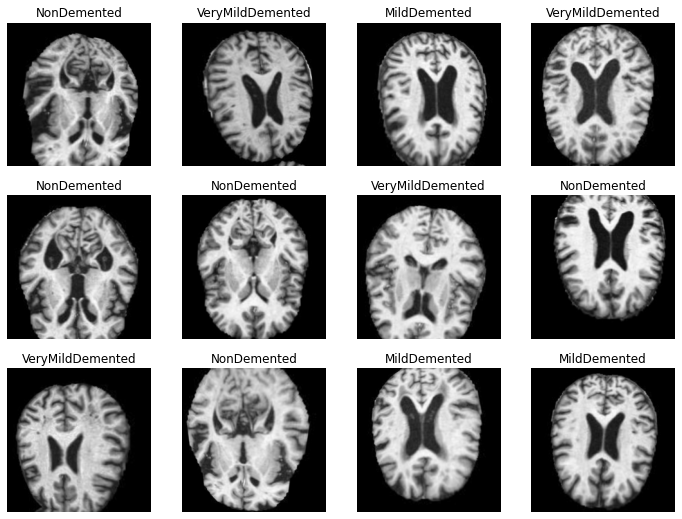

In [6]:
dls.show_batch(max_n=12,nrows=3)
dls.vocab

In [18]:
learn2 = cnn_learner(dls, vgg16_bn, opt_func=Adam, metrics=accuracy, bn_final=True)

In [7]:
learn2.model

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

In [6]:
learn2.summary()

Sequential (Input shape: 20)
Layer (type)         Output Shape         Param #    Trainable 
                     20 x 64 x 224 x 224 
Conv2d                                    1792       False     
BatchNorm2d                               128        True      
ReLU                                                           
Conv2d                                    36928      False     
BatchNorm2d                               128        True      
ReLU                                                           
MaxPool2d                                                      
____________________________________________________________________________
                     20 x 128 x 112 x 11 
Conv2d                                    73856      False     
BatchNorm2d                               256        True      
ReLU                                                           
Conv2d                                    147584     False     
BatchNorm2d                               

epoch,train_loss,valid_loss,accuracy,time
0,1.173751,1.064124,0.602344,02:18


epoch,train_loss,valid_loss,accuracy,time
0,0.998133,0.895465,0.692187,02:49
1,0.876530,0.764983,0.745313,02:48
2,0.755444,0.655682,0.793750,02:48
3,0.636638,0.572291,0.846094,02:48
4,0.518314,0.480959,0.860937,02:48
5,0.433646,0.347596,0.911719,02:47
6,0.362929,0.377426,0.860937,02:51
7,0.303434,0.280114,0.907031,02:47
8,0.269405,0.252297,0.913281,02:51
9,0.218859,0.243044,0.917969,02:46


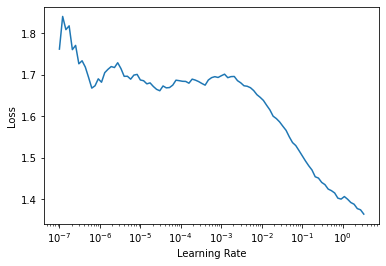

In [8]:
learn2.lr_find()
#learn2 = cnn_learner(dls, resnet50, metrics=error_rate)
learn2.fine_tune(30)

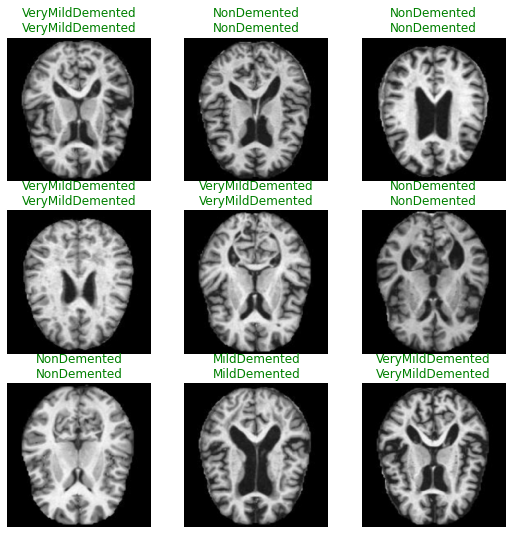

In [11]:
learn2.show_results()

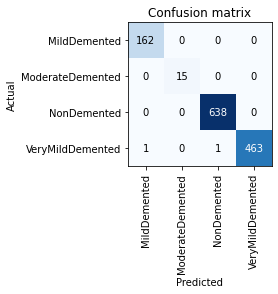

In [12]:
interp2 = ClassificationInterpretation.from_learner(learn2)
interp2.plot_confusion_matrix()

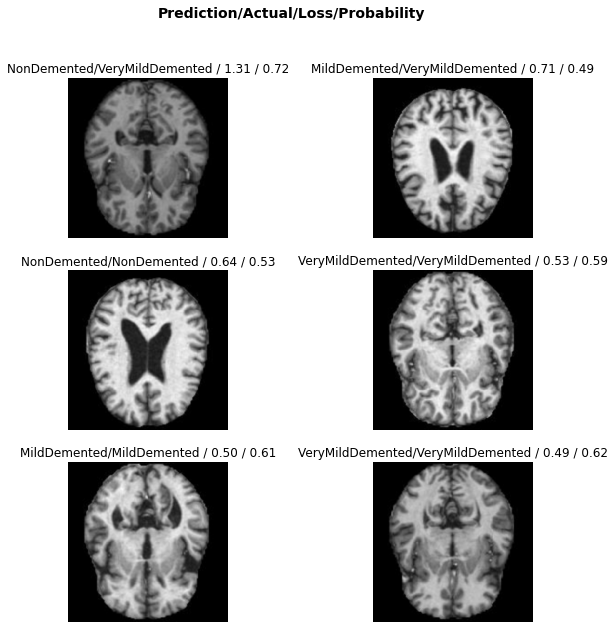

In [13]:
interp2.plot_top_losses(6, nrows=3, figsize = (10,10))

In [14]:
learn2.model_dir = "C:/Users/dinor/EjerciciosPython/TFM/Guardado"
learn2.save("alzheimerVgg16v2")
#learn.export()

Path('C:/Users/dinor/EjerciciosPython/TFM/Guardado/alzheimerVgg16v2.pth')

In [19]:
learn = learn2.load('C:/Users/dinor/EjerciciosPython/TFM/Guardado/alzheimerVgg16v2')

In [16]:
ev = learn.validate()
print('Results from test set \t Accuracy:', float(ev[1]))

Results from test set 	 Accuracy: 0.9984375238418579


## Intento 1 de CAM (Nube de puntos)

In [8]:
k = tensor([
    [0.  , -5/3 , 1],
    [-5/3, -5/3 , 1],
    [1.  , 1    , 1],
]).expand(1, 3, 3, 3)/6

In [11]:
k.shape

torch.Size([1, 3, 3, 3])

In [32]:
from PIL import Image
from torchvision import transforms
img2 = 'C:/Users/dinor/EjerciciosPython/TFM/JPG/brainNon1.JPG'
pil_img = Image.open(img2)
print(pil_img.size)  
 
pil_to_tensor = transforms.ToTensor()(pil_img).unsqueeze_(0)
print(pil_to_tensor.shape) 

(155, 241)
torch.Size([1, 3, 241, 155])


In [33]:
edge = F.conv2d(pil_to_tensor, k)

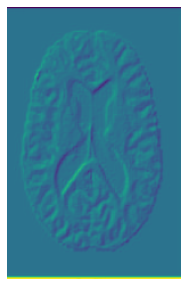

In [34]:
show_image(edge[0], figsize=(5,5))

In [21]:
learn.fit_one_cycle(2, slice(2e-5, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.026848,0.006138,1.000000,02:28
1,0.036695,0.006691,1.000000,02:12


In [22]:
learn.save("forHeatMap")

Path('models/forHeatMap.pth')

(153, 239)


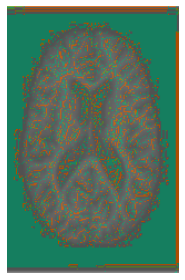

In [50]:
from torchcam.utils import overlay_mask

tensor_to_pil = transforms.ToPILImage()(edge[0].squeeze_(0))
print(tensor_to_pil.size)

result = overlay_mask(pil_img, tensor_to_pil, colormap = 'Dark2', alpha=0.2)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

## Intento 2.1 de CAM (GradCAMpp)

In [30]:
from PIL import Image, ImageStat 
from torchcam.cams import GradCAMpp
from torchvision import transforms
pic = 'brain2.jpg'
picR = Image.open('C:/Users/dinor/EjerciciosPython/TFM/JPG/'+pic)
model = vgg16(pretrained=True).eval()
cam_extractor = GradCAMpp(model)
print(picR.shape)
img = read_image('C:/Users/dinor/EjerciciosPython/TFM/JPG/'+pic)

imgTensor = transforms.ToTensor()(picR).unsqueeze_(0)
stdTensor = torch.std(imgTensor)
meanTensor = torch.mean(imgTensor)

input_tensor = normalize(resize(img, (picR.shape)) / 255., meanTensor, stdTensor)
                         #ImageStat.Stat(picR).mean,
                         #ImageStat.Stat(picR).stddev)
print(input_tensor.shape)

out = model(input_tensor.unsqueeze(0))
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

(750, 1200)
torch.Size([3, 750, 1200])


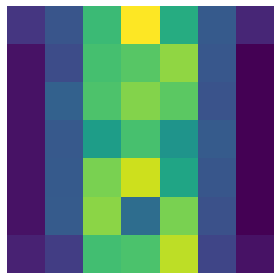

In [31]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map.numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

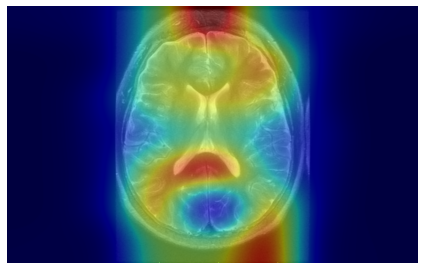

In [32]:
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it

result = overlay_mask(picR, to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

## Intento 2 de CAM (SmoothGradCAMpp)

In [154]:
from PIL import Image, ImageStat 
img = Image.open('C:/Users/dinor/EjerciciosPython/TFM/JPG/brain6.jpg')
Mean = ImageStat.Stat(img).mean
print(Mean)
std = ImageStat.Stat(img).stddev
print(std)
print(img.size)

[76.3801051980198, 76.3801051980198, 76.39198638613861]
[65.44382567930599, 65.44382567930599, 65.43405670876712]
(320, 404)


In [164]:
from PIL import Image, ImageStat 
pic = 'brain6.jpg'
picR = Image.open('C:/Users/dinor/EjerciciosPython/TFM/JPG/'+pic)

model = vgg16(pretrained=True).eval()
cam_extractor = SmoothGradCAMpp(model)



# Get your input
img = read_image('C:/Users/dinor/EjerciciosPython/TFM/JPG/'+pic)
# Preprocess it for your chosen model
input_tensor = normalize(resize(img, (picR.shape)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                         #ImageStat.Stat(picR).mean,
                         #ImageStat.Stat(picR).stddev)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)

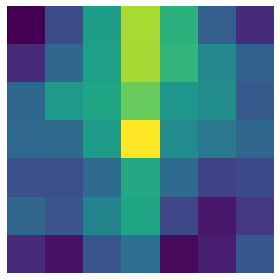

In [165]:
import matplotlib.pyplot as plt
# Visualize the raw CAM
plt.imshow(activation_map.numpy()); plt.axis('off'); plt.tight_layout(); plt.show()

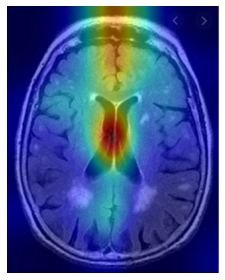

In [166]:
from torchcam.utils import overlay_mask

# Resize the CAM and overlay it

result = overlay_mask(picR, to_pil_image(activation_map, mode='F'), alpha=0.5)
# Display it
plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

## Predicciones

Text(0.5, 1.0, 'Prediction : NonDemented\nAccuracy : 100.0 %')

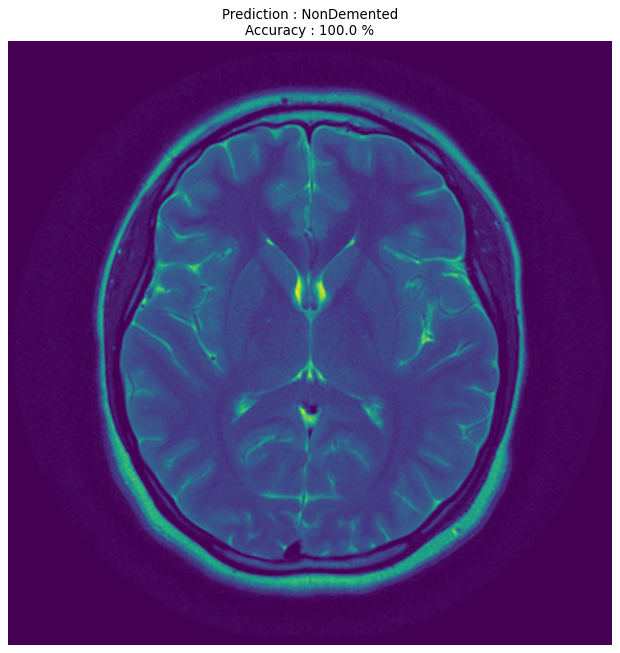

In [56]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/JPEG/brain3.jpeg'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : NonDemented\nAccuracy : 100.0 %')

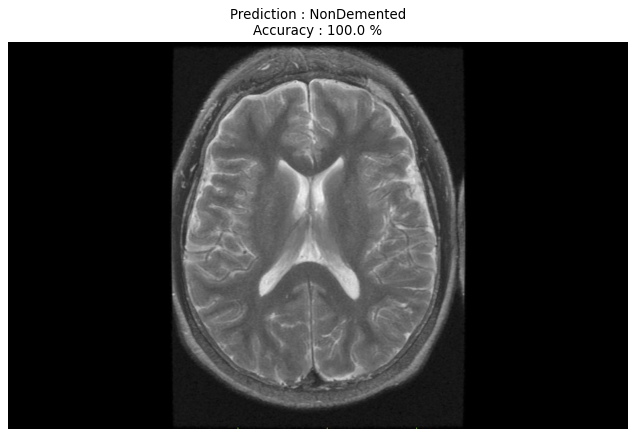

In [13]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/brain2.jpg'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : VeryMildDemented\nAccuracy : 97.88 %')

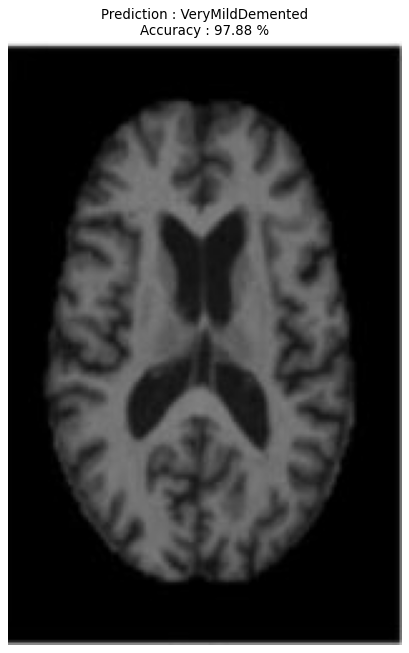

In [14]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/brainVeryWD1.JPG'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : MildDemented\nAccuracy : 99.96 %')

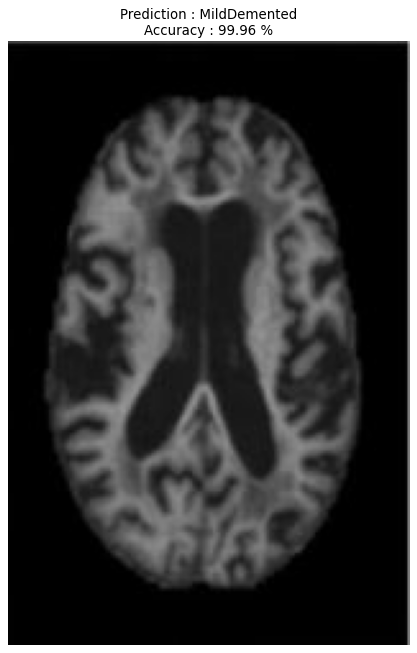

In [15]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/brainWD1.JPG'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : ModerateDemented\nAccuracy : 99.76 %')

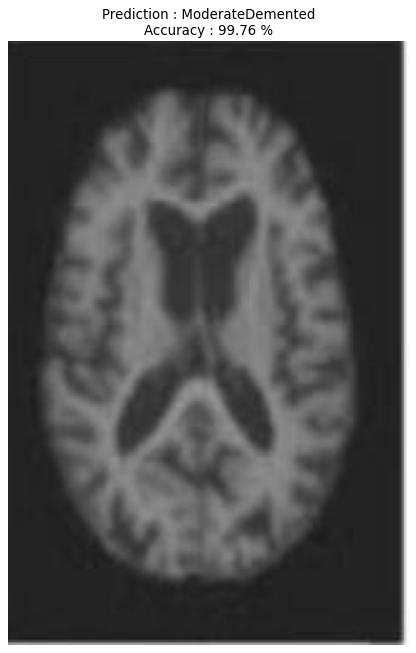

In [17]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/brainMD1.JPG'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))

Text(0.5, 1.0, 'Prediction : NonDemented\nAccuracy : 93.81 %')

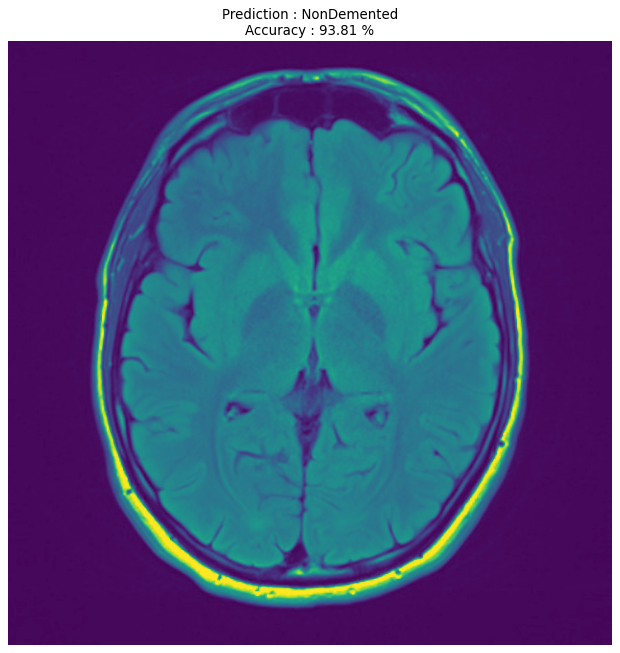

In [25]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
path = 'C:/Users/dinor/EjerciciosPython/TFM/brain.jpeg'
pred = learn2.predict(path)
test_img = Image.open(path)
plt.imshow(test_img)
plt.axis("off")
accuracy_rate = np.round(max(pred[2]).item()*100.0,2)
plt.title("Prediction : {}\nAccuracy : {} %".format(pred[0],accuracy_rate))